<h1 style="text-align:center;">Лабораторная работа №4</h1>

<h3 style="text-align:center;">Осипов Алексей Б01-204</h3>

**Цель**: получить численное решение нелинейной краевой задачи методом стрельбы и методом квазилинеаризации Ньютона

$$
y'' + p \cdot x \cdot \cos(y) = 0, \quad 0 < x \leq 1,
$$

$$
y'(0) = 0, \quad y(1) = 0,
$$

$$
p = 1,\ 4,\ 7,\ 25,\ 50,\ 100.
$$


<h3 style="text-align:center;">Метод стрельбы</h3>

В методе стрельбы мы заменяем краевую задачу на задачу Коши и стараемся подобрать начальное значение так, чтобы удовлетворялось исходное краевое условие на другом конце отрезка, которые мы заменили. Уравнение, которое я взял, является нежёстким, поэтому для решения буду использовать явный метод Рунге-Кутты 4го порядка

Для начала я хочу исследовать, как зависит граничное условие от начального, которое я задаю. Будем смотреть график при разных значениях p, чтобы понять, правильно ли считается граничное значение

In [21]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

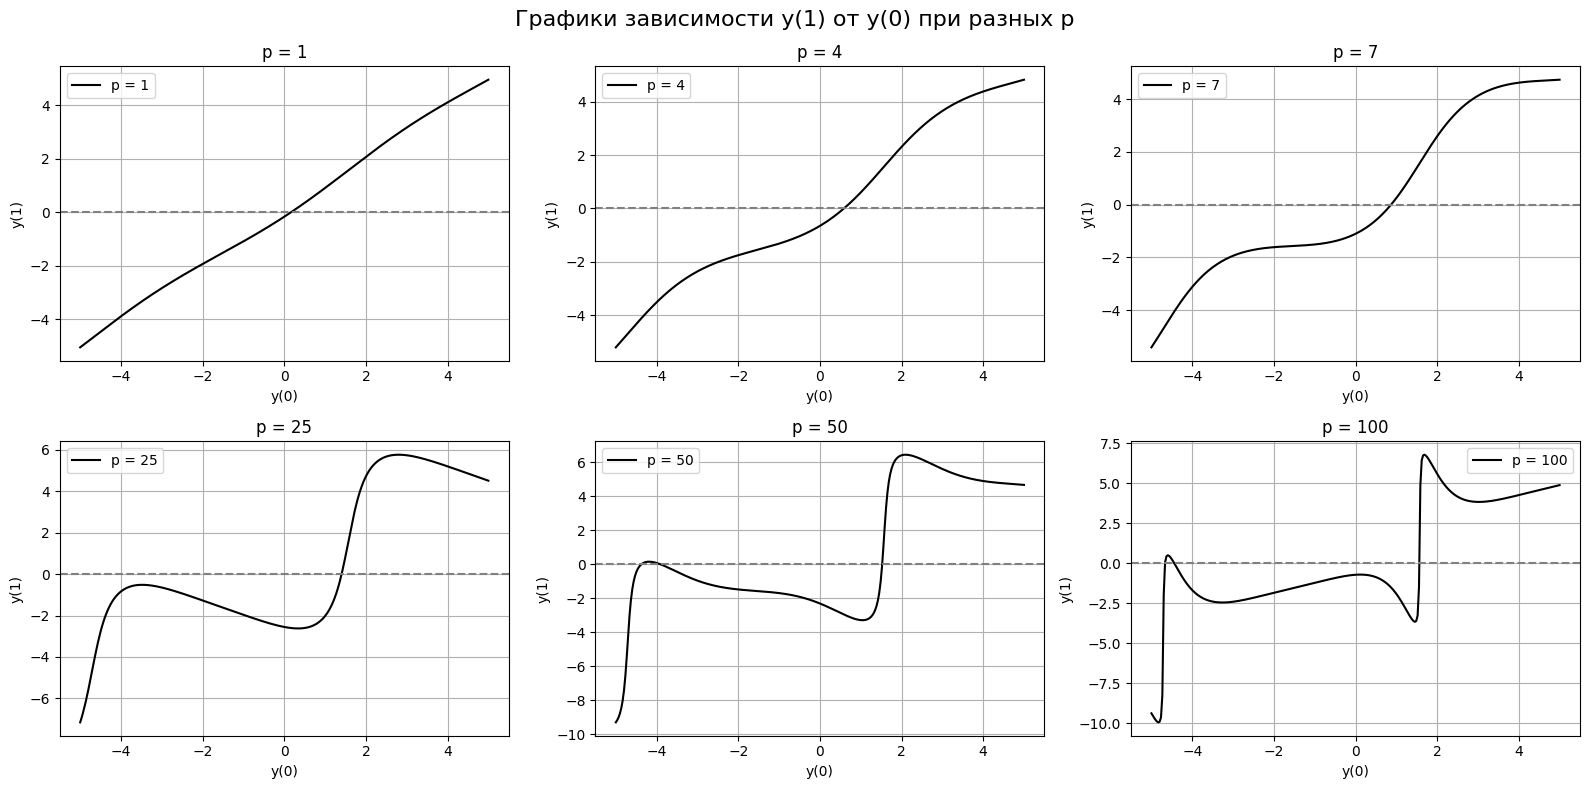

In [ ]:
# Система
def f(x, Y, p):
    y1, y2 = Y
    return np.array([y2, -p * x * np.cos(y1)])

# Метод Рунге-Кутты 4-го порядка
def rk4_step(f, x, Y, h, p):
    k1 = f(x, Y, p)
    k2 = f(x + h/2, Y + h*k1/2, p)
    k3 = f(x + h/2, Y + h*k2/2, p)
    k4 = f(x + h, Y + h*k3, p)
    return Y + h*(k1 + 2*k2 + 2*k3 + k4)/6

# Задача Коши
def solve_ivp(y0, p, h=0.01):
    x = 0
    Y = np.array([y0, 0])
    while x < 1:
        Y = rk4_step(f, x, Y, h, p)
        x += h
    return Y[0]

# Графики
def plots():
    p_values = [1, 4, 7, 25, 50, 100]
    y0_values = np.linspace(-5, 5, 300)

    fig, axs = plt.subplots(2, 3, figsize=(16, 8))
    axs = axs.flatten()

    for i, p in enumerate(p_values):
        y1_values = [solve_ivp(y0, p) for y0 in y0_values]
        axs[i].plot(y0_values, y1_values, color="black",  label=f"p = {p}")
        axs[i].axhline(0, color='gray', linestyle='--')
        axs[i].set_title(f"p = {p}")
        axs[i].set_xlabel("y(0)")
        axs[i].set_ylabel("y(1)")
        axs[i].grid(True)
        axs[i].legend()

    fig.suptitle("Графики зависимости y(1) от y(0) при разных p", fontsize=16)
    plt.tight_layout()
    plt.show()

plots()


Как видно по графикам, при $p = 1, 4, 7$ слагаемое $p \cdot x \cdot \cos(y)$ слабо влияет на решение, зависимость монотонно возрастающая. При больших $p$ система начинает осциллировать, что и даёт пики и провалы, поведение становится нестабильным

Теперь построим график самого решения

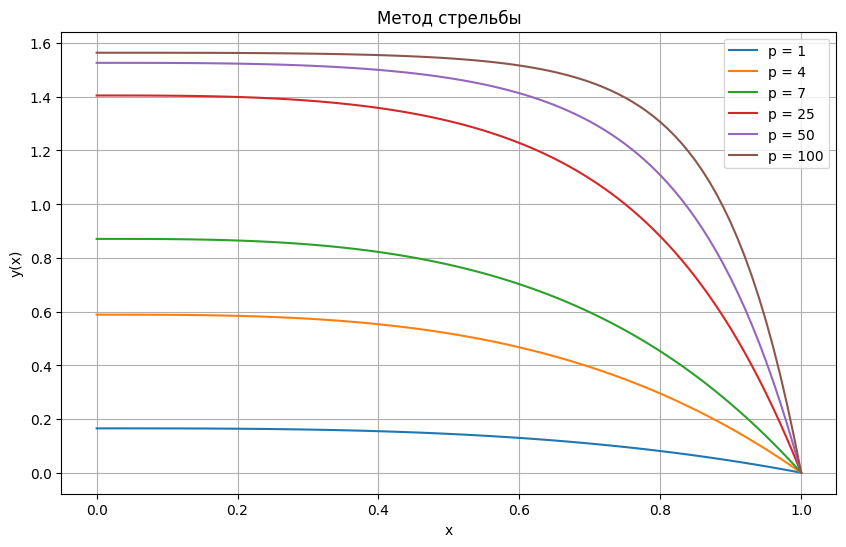

In [19]:
# Метод стрельбы
def shooting_method(p, x1=1.0, y1_target=0.0, h=0.01, tol=1e-5):
    system = f(p)

    def F(y0_guess):
        _, ys = solve_ivp(system, 0, [y0_guess, 0], x1, h)
        return ys[-1] - y1_target

    a, b = -10, 10
    while b - a > tol:
        mid = (a + b) / 2
        if F(a) * F(mid) < 0:
            b = mid
        else:
            a = mid

    y0_final = (a + b) / 2
    xs, ys = solve_ivp(system, 0, [y0_final, 0], x1, h)
    return xs, ys

# Построение графиков для разных p
p_values = [1, 4, 7, 25, 50, 100]
plt.figure(figsize=(10, 6))
for p in p_values:
    xs, ys = shooting_method(p)
    plt.plot(xs, ys, label=f"p = {p}")

plt.title("Метод стрельбы")
plt.xlabel("x")
plt.ylabel("y(x)")
plt.grid(True)
plt.legend()
plt.show()


<h3 style="text-align:center;">Метод квазилинеаризации Ньютона</h3>

Метод Ньютона сводит решение нелинейной краевой задачи к решению серии линейных краевых задач и состоит в следующем.

Пусть для нелинейной краевой задачи  
$$
y'' = f\bigl(x,\,y,\,y'\bigr),
$$  
известна функция $y_0(x)$, удовлетворяющая граничным условиям и грубо приближающаяся к искомому $y(x)$. Положим  
$$
y(x) = y_0(x) + \widetilde v(x),
$$  
где $\widetilde v(x)$ — поправка к нулевому приближению $y_0(x)$. Подставим это в уравнение и разложим по Тейлору до первых порядков:

$$
\begin{aligned}
y''(x) &= y_0''(x) + \widetilde v''(x),\\
f\bigl(x,\,y_0+\widetilde v,\,y_0'+\widetilde v'\bigr)
&= f\bigl(x,\,y_0,\,y_0'\bigr)
+ \frac{\partial f}{\partial y}\bigl(x,y_0,y_0'\bigr)\,\widetilde v
+ \frac{\partial f}{\partial y'}\bigl(x,y_0,y_0'\bigr)\,\widetilde v'
+ O\bigl(\widetilde v^2 + (\widetilde v')^2\bigr).
\end{aligned}
$$

Отбросив член $O(\widetilde v^2 + (\widetilde v')^2)$, получаем линейную краевую задачу для $\widetilde v(x)$ с нулевыми граничными условиями:

$$
\widetilde v''(x)
= p(x)\,\widetilde v'(x)
+ q(x)\,\widetilde v(x)
+ r(x),
\quad
\widetilde v(0)=0,\quad \widetilde v(1)=0,
\tag{3.6}
$$

где

$$
p(x) = \frac{\partial f}{\partial y'}\bigl(x,y_0,y_0'\bigr), 
\quad
q(x) = \frac{\partial f}{\partial y}\bigl(x,y_0,y_0'\bigr), 
\quad
r(x) = f\bigl(x,y_0,y_0'\bigr) - y_0''(x).
\tag{3.7}
$$

Уравнение (3.6) — это уже знакомое линейное уравнение вариаций, но неоднородное. Роль правой части играет невязка нулевого приближения (3.7).

1. Решая линейную задачу (3.6) любым численным методом, находим поправку $\widetilde v(x)$ и принимаем  
   $$
   y_1(x) = y_0(x) + \widetilde v(x)
   $$
   за первое приближение.

2. Зная $y_1(x)$, повторяем процесс: полагаем  
   $$
   y(x) = y_1(x) + \widetilde v_1(x)
   $$
   и решаем следующую линейную краевую задачу для новой поправки $\widetilde v_1(x)$, с коэффициентами, вычисленными по $y_1$, и с новой правой частью — невязкой первого приближения.

3. Продолжаем до тех пор, пока  
   $$
   \max_{x\in[0,1]} \bigl|\widetilde v_k(x)\bigr| \le \varepsilon,
   $$
   где $\varepsilon$ — требуемая точность. Тогда $y_k(x)$ считается искомым решением нелинейной задачи. 


Тогда понятно, что линеаризация Ньютона требует как минимум хорошего начального приближения, иначе даже при $p$ средней величины невязка $r_i = f_i - y''_i$ уже большая. Тогда попробуем брать начальное приближение близко к тому, что даёт метод стрельбы

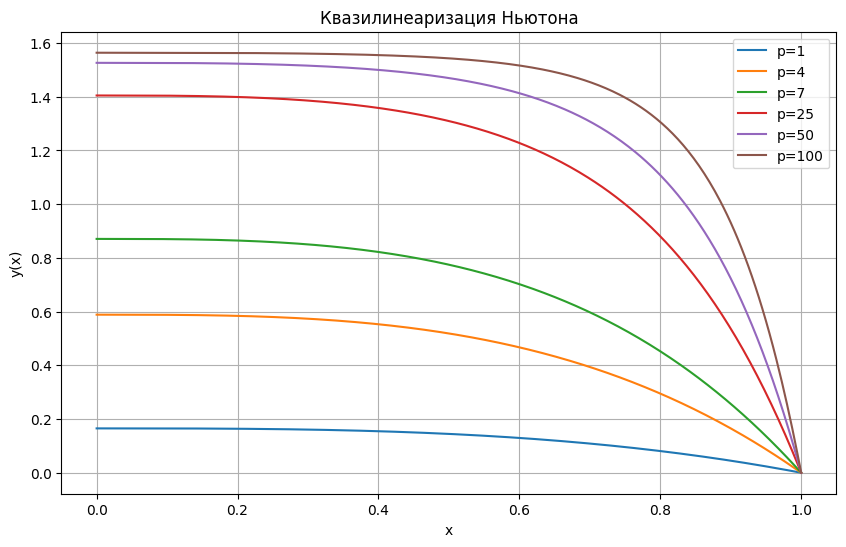

In [31]:
def solve_quasilinear(p, N=400, max_iter=20, tol=1e-6, alpha=0.5):
    h = 1.0/N
    x = np.linspace(0, 1, N+1)

    # Стартуем от решения стрельбой
    y0 = shooting_method(p, x1=1.0, h=h, tol=tol)
    y = np.linspace(y0, 0, N+1)

    for _ in range(max_iter):
        f_i = -p * x * np.cos(y)
        q_i =  p * x * np.sin(y)

        ypp = np.zeros_like(y)
        ypp[1:-1] = (y[2:] - 2*y[1:-1] + y[:-2]) / h**2

        # Невязка = y'' - f_i
        r = ypp - f_i

        m = N-1
        ab = np.zeros((3, m))
        R  = r[1:-1] * h**2

        ab[0, :-1] = -1.0
        ab[1, :]   = 2.0 + q_i[1:-1] * h**2
        ab[2, 1:]  = -1.0
        v = la.solve_banded((1,1), ab, R)

        y_new = y.copy()
        y_new[1:-1] += alpha * v

        # Проверка сходимости
        if np.max(np.abs(v)) < tol:
            y = y_new
            break
        y = y_new

    return x, y

# График
plt.figure(figsize=(10,6))
for p in [1, 4, 7, 25, 50, 100]:
    x, y = solve_quasilinear(p)
    plt.plot(x, y, label=f"p={p}")
plt.title("Квазилинеаризация Ньютона")
plt.xlabel("x"); plt.ylabel("y(x)")
plt.grid(True); plt.legend()
plt.show()

Я использовал небольшую модификацию, добавив релаксационный параметр при обновлении $y$: $y_{k+1} = y_{k} + α·v$. Когда я использовал схему по умолчанию (т.е. при $\alpha$ = 1), то уже при средних значениях $p$ поправка к решению получалась большой, и решение улетало в космос. Без этого параметра решения получались адекватными только для малых $p$